# Predicting Customer Lifetime Value - Watson Analytics

### Packages

In [11]:
import numpy as np
from scipy.stats import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from datetime import datetime
from scipy.stats import wilcoxon

### Importing Data

In [3]:
# Set figure parameters
plt.rcParams['figure.figsize'] = [7, 5]
# Import Data
filename = 'watson_analytics.csv'
df = pd.read_csv(filename)
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## Identify Significant Categorical Variables

First, we must identify all the variables that might have significant differences within the subgroups of the category. Because there are 15 categorical variables, we write one piece of code to look at all the categories together. To do this, we create barplots for each variable to see if there are changes in the heights of the bars within each catagory. Then we will run more tests to observe whether the visual difference is statistically significant.

<Figure size 504x360 with 0 Axes>

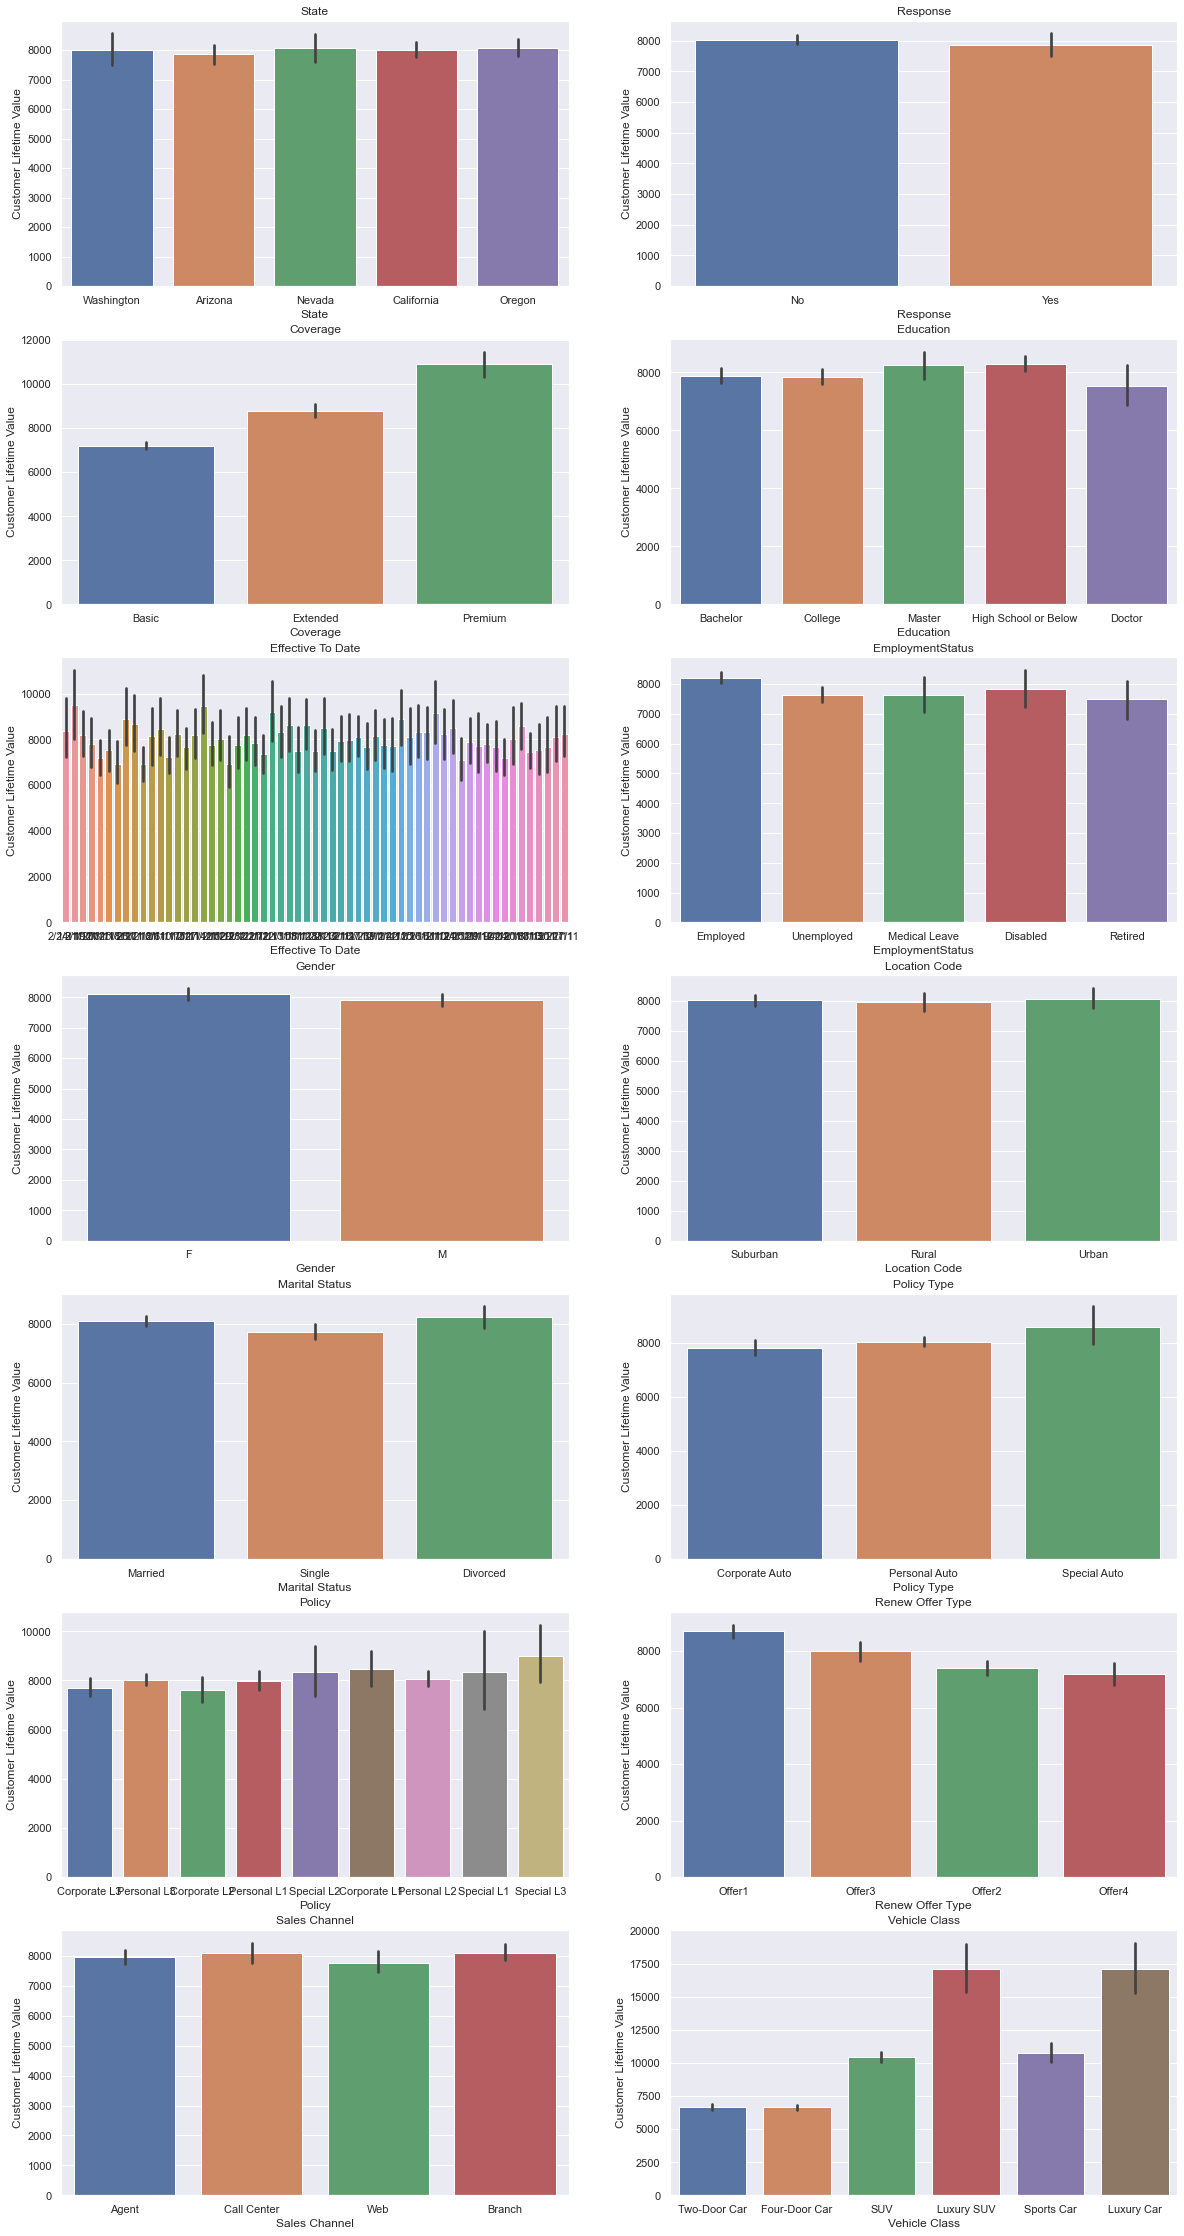

In [6]:
# Get all columns that are categorical
cat_df = df.select_dtypes(include='object')
cat_df = cat_df.drop(['Customer'], axis = 1)
cols = cat_df.columns

# Create a subplot for each category
sns.set(color_codes=True)
plt.subplots_adjust(hspace=0.5)
plt.figure(figsize=(20,40))

for i in range(len(cols) - 1):
    plt.subplot(7,2,i+1)
    sns.barplot(x = cols[i],y='Customer Lifetime Value',data = df)
    plt.title(cols[i])
    
plt.show()

Text(0.5, 1.0, 'Vehicle Size')

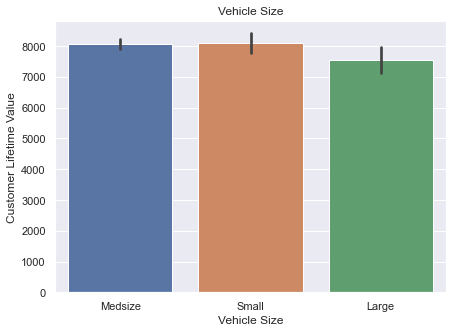

In [7]:
sns.barplot(x = 'Vehicle Size',y='Customer Lifetime Value',data = df)
plt.title('Vehicle Size')

From the barplots, there are significant differences in the sub-groups of the following variables:

* Coverage
* Education
* Employement Status
* Gender
* Marital Status
* Policy Type
* Policy
* Renew Offer Type
* Vehicle Class
* Vehicle Size

We will perform a t-test for Gender since there are only two sub-groups being compared, Male and Female. Then for the other categories, we will conduct a one-way ANOVA test.

### Gender

In [8]:
gender = df[['Customer Lifetime Value','Gender']].groupby('Gender')
female = gender['Customer Lifetime Value'].get_group('F')
male = gender['Customer Lifetime Value'].get_group('M')
stats.ttest_ind(female,male)

Ttest_indResult(statistic=1.300686352501256, pvalue=0.19339865630769232)

Since the p-value < 0.05, then we fail to reject the null hypothesis that there is no statistical significant difference between the mean Customer Lifetime Value of Males and Females. Therefore, Gender will not be included in our predictive models.

### Coverage

In [9]:
coverage = df[['Customer Lifetime Value','Coverage']].groupby('Coverage')
basic = coverage['Customer Lifetime Value'].get_group('Basic')
extended = coverage['Customer Lifetime Value'].get_group('Extended')
premium = coverage['Customer Lifetime Value'].get_group('Premium')
stats.f_oneway(basic,extended,premium)

F_onewayResult(statistic=133.67511419504908, pvalue=6.0158970099807e-58)

The One-Way ANOVA test produces an extremely small p-value, which means that there is a significant difference in the mean CLV for customers with different coverages. We will also look at the distribution of the data to determine whether or not the distributions and median differ between groups as well.

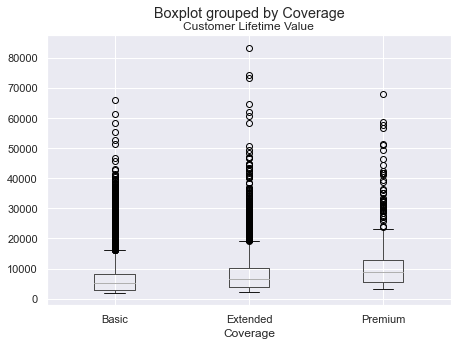

In [10]:
df.boxplot('Customer Lifetime Value', 'Coverage')

Since the median and quartile values increase as the coverage goes from Basic to Premium, this provides more evidence to Coverage being included in the model as changes in coverage are correlated with changes in CLV. 

### Education

In [12]:
education = df[['Customer Lifetime Value','Education']].groupby('Education')
bachelor = education['Customer Lifetime Value'].get_group('Bachelor')
college = education['Customer Lifetime Value'].get_group('College')
master = education['Customer Lifetime Value'].get_group('Master')
high_school = education['Customer Lifetime Value'].get_group('High School or Below')
doctor = education['Customer Lifetime Value'].get_group('Doctor')
stats.f_oneway(bachelor,college,master,high_school,doctor)

F_onewayResult(statistic=2.422865348052191, pvalue=0.04603615409468821)

The test produces an extremely p-value < 0.05, which means that there is a significant difference in the mean CLV for customers with different coverages. We will also look at the distribution of the data through boxplots.

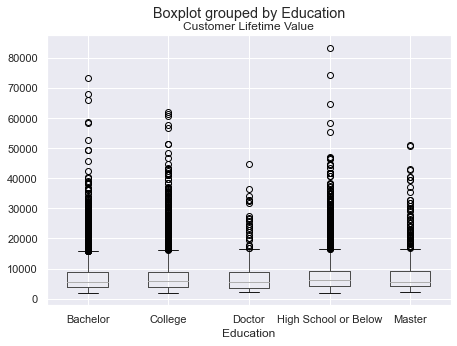

In [13]:
df.boxplot('Customer Lifetime Value', 'Education')

We can see from the boxplots that there is a difference in the medians for each education level, which supports the proposal to include 'Education' in the model.

### Employment Status

In [15]:
employment = df[['Customer Lifetime Value','EmploymentStatus']].groupby('EmploymentStatus')
employed = employment['Customer Lifetime Value'].get_group('Employed')
unemployed = employment['Customer Lifetime Value'].get_group('Unemployed')
medical = employment['Customer Lifetime Value'].get_group('Medical Leave')
disabled = employment['Customer Lifetime Value'].get_group('Disabled')
retired = employment['Customer Lifetime Value'].get_group('Retired')
stats.f_oneway(employed, unemployed, medical, disabled, retired)

F_onewayResult(statistic=3.809808710328605, pvalue=0.00425058662383102)

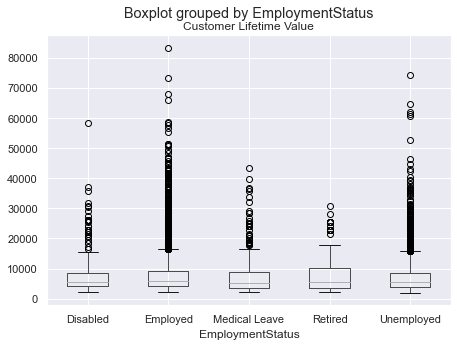

In [16]:
df.boxplot('Customer Lifetime Value', 'EmploymentStatus')

The test produces an extremely p-value < 0.05, which means that there is a significant difference in the mean CLV for customers with different employment statuses. The boxplots also show that the distributions are not the same across each level of employment. Both show that Education Status should be included in the model as it is strongly correlated with CLV.

###  Marital Status

In [17]:
marital = df[['Customer Lifetime Value','Marital Status']].groupby('Marital Status')
single = marital['Customer Lifetime Value'].get_group('Single')
married = marital['Customer Lifetime Value'].get_group('Married')
divorce = marital['Customer Lifetime Value'].get_group('Divorced')
stats.f_oneway(single, married, divorce)

F_onewayResult(statistic=3.3176649375891385, pvalue=0.036281036735873)

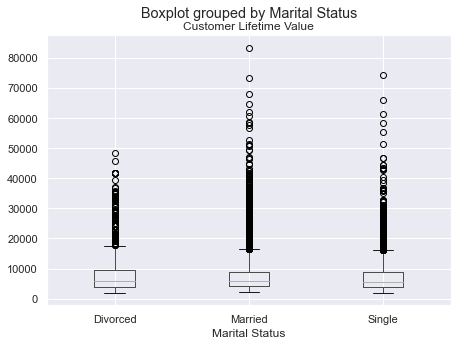

In [18]:
df.boxplot('Customer Lifetime Value', 'Marital Status')

The test produces an extremely p-value < 0.05, which means that there is a significant difference in the mean CLV for customers with different marital statuses. The boxplots also show that the distributions are not the same as the distribution for divorced people is less skewed than married and single people. Both show that Marital Status should be included in the model as it is strongly correlated with CLV.

### Policy Type

In [19]:
policy_type = df[['Customer Lifetime Value','Policy Type']].groupby('Policy Type')
corporate = policy_type['Customer Lifetime Value'].get_group('Corporate Auto')
special = policy_type['Customer Lifetime Value'].get_group('Special Auto')
personal = policy_type['Customer Lifetime Value'].get_group('Personal Auto')
stats.f_oneway(corporate, special, personal)

F_onewayResult(statistic=2.183644634048655, pvalue=0.11268909882175004)

Since the p-value > 0.05, we fail to reject the null hypothesis that there is no statistical difference between the sub-groups of Policy Type. Therefore, we do not include Policy Type in the model.

### Policy

In [20]:
policy = df[['Customer Lifetime Value','Policy']].groupby('Policy')
cl3 = policy['Customer Lifetime Value'].get_group('Corporate L3')
pl3 = policy['Customer Lifetime Value'].get_group('Personal L3')
sl3 = policy['Customer Lifetime Value'].get_group('Special L3')
cl2 = policy['Customer Lifetime Value'].get_group('Corporate L2')
pl2 = policy['Customer Lifetime Value'].get_group('Personal L2')
sl2 = policy['Customer Lifetime Value'].get_group('Special L2')
cl1 = policy['Customer Lifetime Value'].get_group('Corporate L1')
pl1 = policy['Customer Lifetime Value'].get_group('Personal L1')
sl1 = policy['Customer Lifetime Value'].get_group('Special L1')
stats.f_oneway(cl3,pl3,sl3,cl2,pl2,sl2,cl1,pl1,sl1)

F_onewayResult(statistic=1.1839990669675131, pvalue=0.3041951364145143)

Since the p-value > 0.05, we fail to reject the null hypothesis that there is no statistical difference between the sub-groups of Policy. Therefore, we do not include Policy in the model.

### Renew Offer Type

In [21]:
renew = df[['Customer Lifetime Value','Renew Offer Type']].groupby('Renew Offer Type')
offer1 = renew['Customer Lifetime Value'].get_group('Offer1')
offer2 = renew['Customer Lifetime Value'].get_group('Offer2')
offer3 = renew['Customer Lifetime Value'].get_group('Offer3')
offer4 = renew['Customer Lifetime Value'].get_group('Offer4')
stats.f_oneway(offer1,offer2,offer3,offer4)

F_onewayResult(statistic=25.83261444494041, pvalue=1.238399930571374e-16)

The One-Way ANOVA test produces an extremely small p-value, which means that there is a significant difference in the mean CLV for customers with different renew offer types. We will also look at the distribution of the data to determine whether or not the distributions and median differ between groups as well.

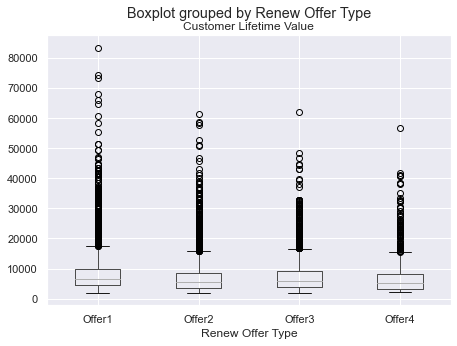

In [22]:
df.boxplot('Customer Lifetime Value', 'Renew Offer Type')

We can see that Offer 1 has a higher median CLV than the offers and Offer 3 has a higher median value that Offers 2 and 4. Therefore we must include Renew Offer Type as a categorical variable.

### Vehicle Class

From the barplots, it appears there is only a difference between cars in the following classes: Luxury, SUV or Sports, and Two-Door/Four-Door cars. Therefore, we only have to create three different sub-groups for this variable.

In [33]:
vehicle_class = df[['Customer Lifetime Value','Vehicle Class']].groupby('Vehicle Class')
luxury = pd.concat([vehicle_class['Customer Lifetime Value'].get_group('Luxury SUV'), 
           vehicle_class['Customer Lifetime Value'].get_group('Luxury Car')], axis = 0)
door = pd.concat([vehicle_class['Customer Lifetime Value'].get_group('Two-Door Car'), 
           vehicle_class['Customer Lifetime Value'].get_group('Four-Door Car')], axis = 0)
other = pd.concat([vehicle_class['Customer Lifetime Value'].get_group('SUV'), 
           vehicle_class['Customer Lifetime Value'].get_group('Sports Car')], axis = 0)
stats.f_oneway(luxury, door, other)

F_onewayResult(statistic=667.578688085395, pvalue=2.5571417337507106e-271)

The One-Way ANOVA test produces an extremely small p-value, which means that there is a significant difference in the mean CLV for customers with different vehicle classes. Hence, the three types of vehicle classes will be included in the model.

### Vehicle Size

In [34]:
v_size = df[['Customer Lifetime Value','Vehicle Size']].groupby('Vehicle Size')
small = v_size['Customer Lifetime Value'].get_group('Small')
medsize = v_size['Customer Lifetime Value'].get_group('Medsize')
large = v_size['Customer Lifetime Value'].get_group('Large')
stats.f_oneway(small, medsize, large)

F_onewayResult(statistic=2.382494601032998, pvalue=0.09237737701331775)

We will not include vehicle size in the model as the p-value is greater than 0.05.

Therefore, the categorical variables to be included in the model are
* Coverage
* Education
* Employement Status
* Marital Status
* Renew Offer Type
* Vehicle Class

We will create dummy variables for the sub-categories in each variable to be used in the model. A 1 in the column indicates that this sub-category is true for the customer and a 0 indicates that it is not.

In [35]:
coverage = pd.get_dummies(df['Coverage'])
education = pd.get_dummies(df['Education'])
employment = pd.get_dummies(df['EmploymentStatus'])
marital_status = pd.get_dummies(df['Marital Status'])
renew_offer_type = pd.get_dummies(df['Renew Offer Type'])
searchfor = ['SUV', 'Sports']
df['Luxury'] = np.where(df['Vehicle Class'].str.contains('Luxury'), 1, 0)
df['Two/Four-Door'] = np.where(df['Vehicle Class'].str.contains('Door'), 1, 0)
df['SUV/Sports Car'] = np.where(df['Vehicle Class'].str.contains('|'.join(searchfor)), 1, 0)

In [40]:
df = pd.concat([df, coverage, education, employment, marital_status, renew_offer_type], axis = 1)
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Medical Leave,Retired,Unemployed,Divorced,Married,Single,Offer1,Offer2,Offer3,Offer4
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,0,0,0,0,1,0,1,0,0,0
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,0,0,1,0,0,1,0,0,1,0
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,0,0,0,0,1,0,1,0,0,0
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,0,0,1,0,1,0,1,0,0,0
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,0,0,0,0,0,1,1,0,0,0
